<a href="https://colab.research.google.com/github/slisovych/machine_learning_hometasks/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import pandas as pd
import numpy as np
import opendatasets as od
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import operator

In [3]:
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=train.csv')

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


Area under ROC score on Training dataset: 0.88%


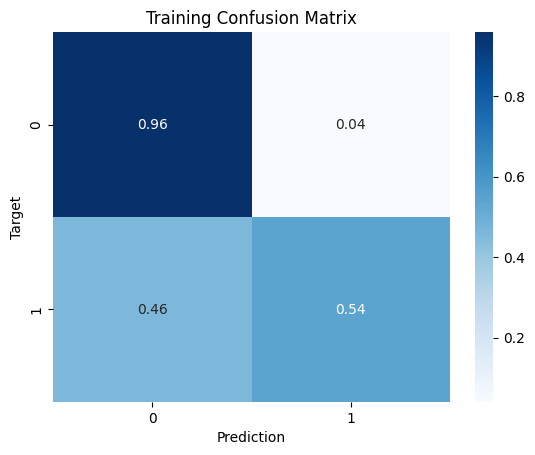

Area under ROC score on Validation dataset: 0.88%


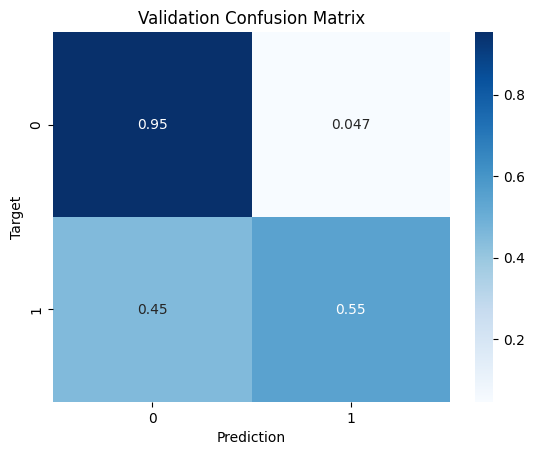

['bank_curn_pipeline.joblib']

In [4]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)
raw_df.drop(columns=['CustomerId'], inplace=True)

y=raw_df['Exited']
train_df, val_df = train_test_split(raw_df, stratify=y, test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = [col for col in train_inputs.select_dtypes(include=np.number).columns if col not in ['id', 'Surname']]
categorical_cols = [col for col in train_inputs.select_dtypes(include='object').columns if col not in ['id', 'Surname']]


# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    preds_proba = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, preds_proba)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_curn_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Training dataset: 0.91%


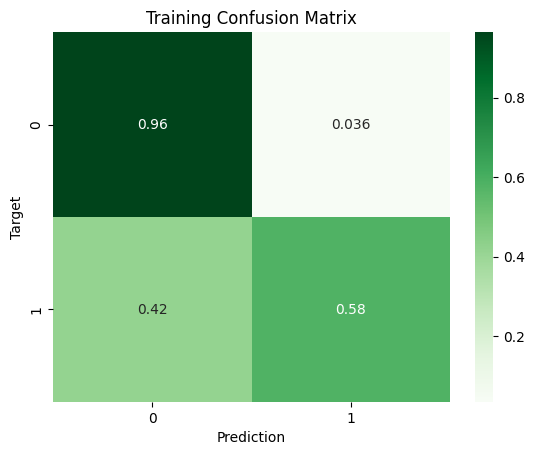

Area under ROC score on Validation dataset: 0.91%


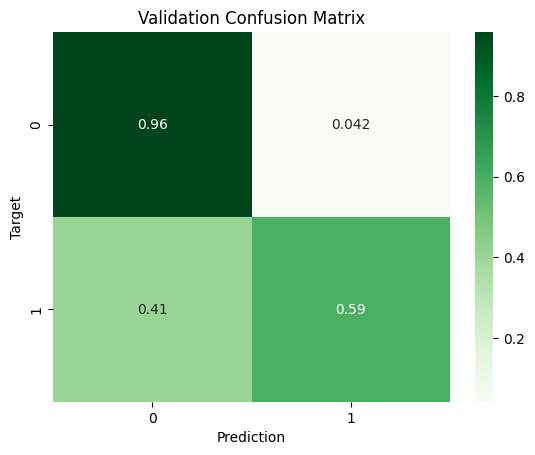

In [5]:
# Створюємо трансформери для числових і категоріальних колонок
poly_numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler())
])

poly_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
poly_preprocessor = ColumnTransformer(
    transformers=[
        ('num', poly_numeric_transformer, numeric_cols),
        ('cat', poly_categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
poly_model_pipeline = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
poly_model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(poly_model_pipeline, inputs, targets, name=''):
    poly_preds = poly_model_pipeline.predict(inputs)
    poly_preds_proba = poly_model_pipeline.predict_proba(inputs)[:, 1]
    poly_roc_auc = roc_auc_score(targets, poly_preds_proba)
    print(f"Area under ROC score on {name} dataset: {poly_roc_auc:.2f}%")
    poly_confusion_matrix_ = confusion_matrix(targets, poly_preds, normalize='true')
    plt.figure()
    sns.heatmap(poly_confusion_matrix_, annot=True, cmap='Greens')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return poly_preds

# Оцінюємо модель на трен і вал даних
poly_train_preds = predict_and_plot(poly_model_pipeline, train_inputs, train_targets, 'Training')
poly_val_preds = predict_and_plot(poly_model_pipeline, val_inputs, val_targets, 'Validation')

Модель генералізує добре, оскільки AUC ROC score високий як на тренувальному так і на валідаційному датасеті.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Training dataset: 0.93%


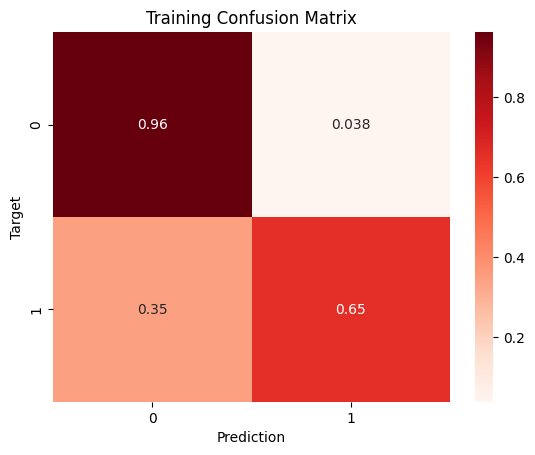

Area under ROC score on Validation dataset: 0.93%


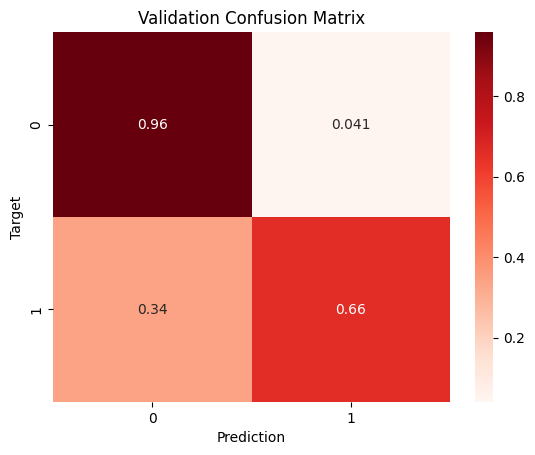

In [6]:
# Створюємо трансформери для числових і категоріальних колонок
poly_numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler())
])

poly_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
poly_preprocessor = ColumnTransformer(
    transformers=[
        ('num', poly_numeric_transformer, numeric_cols),
        ('cat', poly_categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
poly_model_pipeline = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
poly_model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(poly_model_pipeline, inputs, targets, name=''):
    poly_preds = poly_model_pipeline.predict(inputs)
    poly_preds_proba = poly_model_pipeline.predict_proba(inputs)[:, 1]
    poly_roc_auc = roc_auc_score(targets, poly_preds_proba)
    print(f"Area under ROC score on {name} dataset: {poly_roc_auc:.2f}%")
    poly_confusion_matrix_ = confusion_matrix(targets, poly_preds, normalize='true')
    plt.figure()
    sns.heatmap(poly_confusion_matrix_, annot=True, cmap='Reds')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return poly_preds

# Оцінюємо модель на трен і вал даних
poly_train_preds = predict_and_plot(poly_model_pipeline, train_inputs, train_targets, 'Training')
poly_val_preds = predict_and_plot(poly_model_pipeline, val_inputs, val_targets, 'Validation')

In [7]:
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv', index_col=0)

test_preds = poly_model_pipeline.predict(test_raw_df)

test_raw_df['Exited'] = test_preds
test_raw_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0
15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.0
15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.0
15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0
15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0


In [8]:
submission_log_reg = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv', index_col=0)

submission_log_reg['Exited'] = test_raw_df['Exited'].values
submission_log_reg.to_csv('submission_log_reg.csv')


In [9]:
print("Train class distribution:\n", train_df['Exited'].value_counts(normalize=True))
print("Validation class distribution:\n", val_df['Exited'].value_counts(normalize=True))
print("Test class distribution:\n", test_raw_df['Exited'].value_counts(normalize=True))


Train class distribution:
 Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64
Validation class distribution:
 Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64
Test class distribution:
 Exited
0.0    0.8267
1.0    0.1733
Name: proportion, dtype: float64


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
reg_raw_df = pd.read_csv('drive/MyDrive/Colab Notebooks/ML_Hanna_Pylieva/data/regression_data.csv')
reg_raw_df

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013
...,...,...,...,...,...,...
124,1.402794,0.586857,-1.401851,0.791032,-0.909387,39.626185
125,-0.288659,-0.827231,0.322719,-1.002529,-0.018513,-50.585687
126,-1.407464,-0.213447,-0.718444,0.232050,-1.448084,13.719861
127,1.353872,1.237816,-0.114540,-0.469176,-1.713135,-23.851350


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [28]:
 !pip install -U scikit-learn

In [23]:
X = reg_raw_df.drop('target', axis=1)
y = reg_raw_df['target']

# Розбивка на тренувальні та вал. дані
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Масштабування
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [33]:
def train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree):
  # Звичайна лінійна регресія
  lin_reg = LinearRegression()
  lin_reg.fit(X_train, y_train)
  y_pred_train_lin = lin_reg.predict(X_train)
  y_pred_test_lin = lin_reg.predict(X_test)

  # Поліноміальна регресія
  poly_features = PolynomialFeatures(degree=degree)
  X_train_poly = poly_features.fit_transform(X_train)
  X_test_poly = poly_features.transform(X_test)

  print(f'В оригіналній матриці Х {X.shape[1]} ознак.')
  print(f'В матриці Х з поліноміальними ознаками {X_train_poly.shape[1]} ознак.\n')

  poly_reg = LinearRegression()
  poly_reg.fit(X_train_poly, y_train)
  y_pred_train_poly = poly_reg.predict(X_train_poly)
  y_pred_test_poly = poly_reg.predict(X_test_poly)

  # Оцінка моделей
  rmse_lin_train = np.sqrt(mean_squared_error(y_train, y_pred_train_lin))
  rmse_poly_train = np.sqrt(mean_squared_error(y_train, y_pred_train_poly))

  rmse_lin_test = np.sqrt(mean_squared_error(y_test, y_pred_test_lin))
  rmse_poly_test = np.sqrt(mean_squared_error(y_val, y_pred_test_poly))


  print(f"Train RMSE for Linear Regression: {np.sqrt(rmse_lin_train):.3f}")
  print(f"Test RMSE for Linear Regression: {np.sqrt(rmse_lin_test):.3f}\n")

  print(f"Train RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_train):.3f}")
  print(f"Test RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_test):.3f}")

In [34]:
degree = 2
train_lin_vs_poly_reg_and_plot(X_train, X_test, y_train, y_test, degree)

В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 21 ознак.

Train RMSE for Linear Regression: 1.033
Test RMSE for Linear Regression: 0.940

Train RMSE for Polynomial Regression (degree 2): 1.008
Test RMSE for Polynomial Regression (degree 2): 1.007


In [35]:
degree = 3
train_lin_vs_poly_reg_and_plot(X_train, X_test, y_train, y_test, degree)

В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 56 ознак.

Train RMSE for Linear Regression: 1.033
Test RMSE for Linear Regression: 0.940

Train RMSE for Polynomial Regression (degree 3): 0.894
Test RMSE for Polynomial Regression (degree 3): 1.384


In [37]:
degree = 5
train_lin_vs_poly_reg_and_plot(X_train, X_test, y_train, y_test, degree)

В оригіналній матриці Х 5 ознак.
В матриці Х з поліноміальними ознаками 252 ознак.

Train RMSE for Linear Regression: 1.033
Test RMSE for Linear Regression: 0.940

Train RMSE for Polynomial Regression (degree 5): 0.000
Test RMSE for Polynomial Regression (degree 5): 4.165


Лінійна регресія є найкращою, бо вона не має проблем із узагальненням.

Поліноміальна регресія (степінь 3) вже перетренувалася, і її точність на тестових даних впала.

Поліноміальна регресія (степінь 5) повністю запам’ятала тренувальні дані, але жахливо працює на тестових, тому є абсолютно непридатною для прогнозування.
Оптимальне рішення:

Зупинитися на лінійній регресії або, якщо потрібно поліноміальну модель, обмежитися степенем 2.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [45]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(6)
    test_metrics = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(6)

    return dict(train=train_metrics, test=test_metrics)

In [46]:
degree = 20
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
for model in models:
    model.fit(X_train_poly, y_train)
    eval_results  = evaluate_model(model, X_train_poly, y_train, X_test_poly, y_test)
    print(f'{str(model)}: {eval_results}\n')


Ridge(): {'train': 5.885065, 'test': 7.02105}

Ridge(alpha=2): {'train': 7.92074, 'test': 8.614413}

Lasso(): {'train': 5.098171, 'test': 5.671931}

ElasticNet(): {'train': 30.034532, 'test': 30.442414}

ElasticNet(alpha=0.5): {'train': 23.835943, 'test': 23.298833}



Lasso-регресія (L1-регуляризація)

Train RMSE = 5.098, Test RMSE = 5.672 → найкращий баланс між навчанням і тестуванням.

Найменша тестова помилка (5.672) серед усіх моделей.

Висновок: Lasso є найкращим варіантом, оскільки воно добре справляється з великим числом ознак і контролює переобучення.